# Random Forest Tutorial - Adult Census Income (MSc Data Science)

 **This tutorial demonstrates how to build, tune, and interpret a Random Forest model using the Adult Census Income dataset.**
- Covers the full workflow : data preprocessing, exploratory visualisation, baseline modelling, hyperparameter tuning with cross-validation, and permutation-based feature importance analysis.

- Provides clear, student-friendly explanations at each stage to support understanding in both theory and practice.

- Designed for MSc Data Science students to not only observe the model’s predictions, but also understand the reasoning behind them through interpretability tools and fairness-aware evaluation.

- Produces high-quality visualisations suitable for academic reports and teaching demonstrations.

- Dataset: https://www.kaggle.com/datasets/uciml/adult-census-income


# 1. Imports and Global Settings

In [6]:
# SECTION 1 – Imports and global configuration
# In this cell we import all necessary libraries for data handling, modelling,
# and visualisation. We also fix a random seed and configure plot style to keep
# the entire tutorial visually consistent and reproducible.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)
from sklearn.inspection import permutation_importance

# Global visual style: clean grid, decent figure sizes and colour-blind-friendly palette
sns.set(style="whitegrid", palette="colorblind")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# 2. Helper Plotting Functions

In [7]:
# SECTION 2 – Custom plotting utilities
# This cell defines reusable plotting functions that produce clear, colourful
# and accessible figures. These help keep the main analysis code clean while
# also giving you high-quality visuals for your tutorial and report.

def plot_class_distribution(y, title="Class distribution of income"):
    """
    Plot the class distribution of the target variable.
    Helpful for explaining class imbalance to the audience.
    """
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x=y, palette=sns.color_palette("Set2"))
    ax.set_xticklabels(["<=50K (0)", ">50K (1)"])
    plt.title(title, fontsize=13, fontweight="bold")
    plt.xlabel("Income class", fontsize=11)
    plt.ylabel("Number of samples", fontsize=11)
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix_pretty(y_true, y_pred, title="Confusion Matrix"):
    """
    Plot a confusion matrix with both raw counts and percentages.
    Uses a soft pink-toned palette for a modern but readable aesthetic.
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(6, 5))
    cmap = sns.light_palette("#FF7FBB", as_cmap=True)

    ax = sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=cmap,
        cbar=False,
        linewidths=0.8,
        linecolor="white",
        square=True,
        annot_kws={"size": 13, "weight": "bold", "color": "black"}
    )

    # Add percentage labels slightly below the counts
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j + 0.5,
                i + 0.8,
                f"{cm_percent[i, j] * 100:.1f}%",
                ha="center",
                va="center",
                fontsize=9,
                color="black"
            )

    plt.title(title, fontsize=14, fontweight="bold")
    plt.xlabel("Predicted label", fontsize=11)
    plt.ylabel("True label", fontsize=11)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


def plot_roc_comparison(y_true, y_proba_baseline, y_proba_tuned):
    """
    Plot ROC curves for baseline and tuned models on the same axes.
    This is ideal to visually demonstrate the impact of hyperparameter tuning.
    """
    plt.figure(figsize=(7, 6))
    ax = plt.gca()

    RocCurveDisplay.from_predictions(
        y_true, y_proba_baseline, name="Baseline RF", ax=ax
    )
    RocCurveDisplay.from_predictions(
        y_true, y_proba_tuned, name="Tuned RF", ax=ax
    )

    # Diagonal "random guess" line
    ax.plot([0, 1], [0, 1], linestyle="--", color="grey", label="Random guess")

    # Customise colours and line styles
    lines = ax.lines
    if len(lines) >= 2:
        lines[0].set_color("#1f77b4")   # blue
        lines[0].set_linewidth(2.0)
        lines[1].set_color("#ff7f0e")   # orange
        lines[1].set_linewidth(2.0)

    ax.set_title("ROC Curves – Baseline vs Tuned Random Forest", fontsize=14, fontweight="bold")
    ax.set_xlabel("False Positive Rate", fontsize=11)
    ax.set_ylabel("True Positive Rate", fontsize=11)
    ax.grid(alpha=0.3, linestyle="--")
    ax.legend(loc="lower right", fontsize=10)
    plt.tight_layout()
    plt.show()


def plot_metric_bar_comparison(metrics_baseline, metrics_tuned):
    """
    Plot a grouped bar chart comparing baseline vs tuned model across metrics.
    This works very well in a tutorial to summarise performance at a glance.
    """
    metric_names = list(metrics_baseline.keys())
    baseline_vals = [metrics_baseline[m] for m in metric_names]
    tuned_vals = [metrics_tuned[m] for m in metric_names]

    x = np.arange(len(metric_names))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, baseline_vals, width, label="Baseline", color="#4C72B0")
    plt.bar(x + width/2, tuned_vals, width, label="Tuned", color="#DD8452")

    plt.xticks(x, metric_names)
    plt.ylim(0, 1.05)
    plt.ylabel("Score", fontsize=11)
    plt.xlabel("Metric", fontsize=11)
    plt.title("Baseline vs Tuned Random Forest – Metric Comparison", fontsize=14, fontweight="bold")
    plt.legend(fontsize=10)
    plt.grid(axis="y", alpha=0.3, linestyle="--")
    plt.tight_layout()
    plt.show()


def plot_feature_importance_bar(top_importances, title="Top features by permutation importance"):
    """
    Plot the top-k features according to permutation importance as a horizontal bar chart.
    Uses a smooth colour gradient to make the ranking visually engaging.
    """
    plt.figure(figsize=(8, 6))
    colors = sns.color_palette("viridis", n_colors=len(top_importances))

    top_importances.sort_values().plot(
        kind="barh",
        color=colors
    )

    plt.xlabel("Mean decrease in F1 (permutation importance)", fontsize=11)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()


# 3. Load Dataset and Basic Inspection

In [8]:
# SECTION 3 – Load the Adult Census dataset and inspect structure
# In this cell we load the Adult Census Income dataset from CSV, inspect its
# shape, preview a few rows, and check for obvious missing patterns and target
# distribution before any processing or modelling.

data_path = r"C:\Yasaswini Sure\Machine Learning\adult.csv"  # Adjust this path if your file is elsewhere
adult_df = pd.read_csv(data_path)

print("Shape of raw dataset:", adult_df.shape)
print("\nFirst five rows:")
display(adult_df.head())

print("\nDataset info:")
adult_df.info()

print("\nMissing values before cleaning:")
print(adult_df.isna().sum())

# Many Adult dataset variants encode missing values with a "?" placeholder
adult_df = adult_df.replace("?", np.nan)

print("\nMissing values after replacing '?' with NaN:")
print(adult_df.isna().sum())

print("\nRaw income label distribution:")
print(adult_df["income"].value_counts(normalize=True))


Shape of raw dataset: (32561, 15)

First five rows:


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB

Missing values before cleaning:
age               0
workclass         0
fnlwg

# 4. Define Features/Target and Class Balance Plot

Unique binary labels in y: [0 1]

Proportion of each class:
income
0    0.75919
1    0.24081
Name: count, dtype: float64


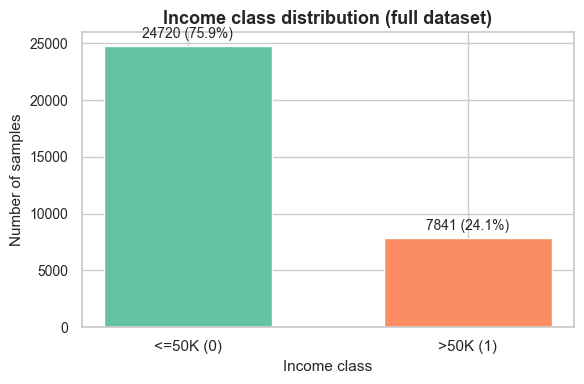

In [9]:
# SECTION 4 – Define X/y and explore target class balance
# This cell constructs the feature matrix X and target vector y, converts
# textual income labels into binary numeric values, displays class proportions,
# and visualises the class distribution with a clean, modern bar plot.

# Separate features and target
X = adult_df.drop(columns=["income"])
y_raw = adult_df["income"]

# Convert income labels into binary classes: 1 = high income, 0 = lower income
y = y_raw.map({
    ">50K": 1,
    ">50K.": 1,
    "<=50K": 0,
    "<=50K.": 0
}).astype(int)

print("Unique binary labels in y:", y.unique())

# Display class proportions
counts = y.value_counts().sort_index()
proportions = counts / counts.sum()

print("\nProportion of each class:")
print(proportions)


# Warning-free, clean, well-annotated matplotlib bar chart
def plot_class_distribution(y, title="Class distribution of income"):
    """
    Plot the target distribution using pure matplotlib to avoid seaborn
    palette warnings. Produces a clean, annotated, publication-quality figure.
    """
    y = pd.Series(y)
    counts = y.value_counts().sort_index()
    proportions = counts / counts.sum()

    fig, ax = plt.subplots(figsize=(6, 4))

    # Two colours for two classes (soft orange and soft blue)
    colors = ["#66c2a5", "#fc8d62"]

    ax.bar([0, 1], counts.values, color=colors, width=0.6)

    # Custom tick labels
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["<=50K (0)", ">50K (1)"], fontsize=11)

    ax.set_xlabel("Income class", fontsize=11)
    ax.set_ylabel("Number of samples", fontsize=11)
    ax.set_title(title, fontsize=13, fontweight="bold")

    # Add value + percentage text above bars
    for i, (count, prop) in enumerate(zip(counts.values, proportions.values)):
        ax.text(
            i,
            count + counts.max() * 0.02,
            f"{count} ({prop*100:.1f}%)",
            ha="center",
            va="bottom",
            fontsize=10
        )

    plt.tight_layout()
    plt.show()


# Plot the final class distribution
plot_class_distribution(y, title="Income class distribution (full dataset)")


# 5. Train–Test Split

In [10]:
# SECTION 5 – Train–test split with stratification
# This cell splits the dataset into training and test sets while preserving
# the income class proportions. Stratification is important for obtaining a
# fair and robust estimate of model performance on unseen data.

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Training set shape:", X_train.shape)
print("Test set shape     :", X_test.shape)

print("\nTraining class balance:")
print(y_train.value_counts(normalize=True))


Training set shape: (26048, 14)
Test set shape     : (6513, 14)

Training class balance:
income
0    0.759175
1    0.240825
Name: proportion, dtype: float64


# 6. Preprocessing Pipelines

In [11]:
# SECTION 6 – Build preprocessing pipelines for numeric and categorical features
# In this cell we identify numeric and categorical columns and create a
# ColumnTransformer. Numeric features are imputed and scaled, while categorical
# features are imputed and one-hot encoded, making the dataset suitable for RF.

numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


Numeric features: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
Categorical features: ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']


# 7. Baseline Random Forest Model + Confusion Matrix

Fitting baseline Random Forest model...

Baseline Random Forest performance on test set:
Accuracy : 0.853
Precision: 0.732
Recall   : 0.614
F1       : 0.668
ROC_AUC  : 0.900

Classification report (baseline model):
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      4945
           1       0.73      0.61      0.67      1568

    accuracy                           0.85      6513
   macro avg       0.81      0.77      0.79      6513
weighted avg       0.85      0.85      0.85      6513



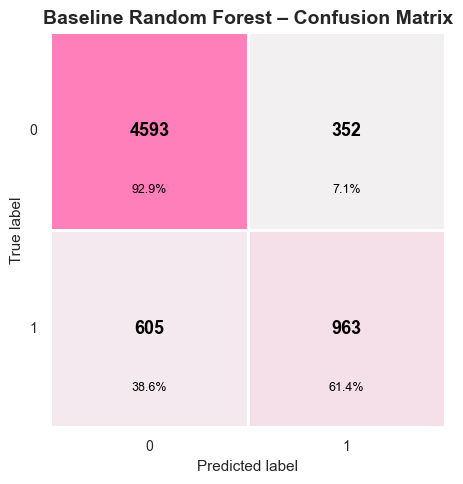

In [12]:
# SECTION 7 – Train a baseline Random Forest and evaluate performance
# This cell fits a reasonably configured baseline Random Forest on the
# preprocessed data, computes core performance metrics, and visualises how
# well it performs using a confusion matrix on the test set.

baseline_rf = RandomForestClassifier(
    n_estimators=200,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

baseline_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", baseline_rf)
])

print("Fitting baseline Random Forest model...")
baseline_pipeline.fit(X_train, y_train)

y_pred_baseline = baseline_pipeline.predict(X_test)
y_proba_baseline = baseline_pipeline.predict_proba(X_test)[:, 1]

baseline_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_baseline),
    "Precision": precision_score(y_test, y_pred_baseline),
    "Recall": recall_score(y_test, y_pred_baseline),
    "F1": f1_score(y_test, y_pred_baseline),
    "ROC_AUC": roc_auc_score(y_test, y_proba_baseline),
}

print("\nBaseline Random Forest performance on test set:")
for metric_name, value in baseline_metrics.items():
    print(f"{metric_name:9s}: {value:.3f}")

print("\nClassification report (baseline model):")
print(classification_report(y_test, y_pred_baseline))

plot_confusion_matrix_pretty(
    y_test,
    y_pred_baseline,
    title="Baseline Random Forest – Confusion Matrix"
)


# 8. Hyperparameter Tuning with RandomizedSearchCV

In [13]:
# SECTION 8 – Hyperparameter tuning with RandomizedSearchCV
# This cell defines a search space over key Random Forest hyperparameters
# and uses RandomizedSearchCV to find a better-performing configuration.
# The focus is on F1-score to balance precision and recall in this context.

rf_for_search = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_for_search)
])

param_distributions = {
    "model__n_estimators": [100, 200, 300, 400, 500],
    "model__max_depth": [None, 5, 10, 15, 20, 30],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 4, 8],
    "model__max_features": ["sqrt", "log2", 0.5, 0.7],
}

random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_distributions,
    n_iter=25,
    scoring="f1",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("Running RandomizedSearchCV for Random Forest tuning...")
random_search.fit(X_train, y_train)

print("\nBest hyperparameters found:")
print(random_search.best_params_)
print("\nBest cross-validation F1-score: {:.3f}".format(random_search.best_score_))

best_pipeline = random_search.best_estimator_


Running RandomizedSearchCV for Random Forest tuning...
Fitting 3 folds for each of 25 candidates, totalling 75 fits

Best hyperparameters found:
{'model__n_estimators': 200, 'model__min_samples_split': 20, 'model__min_samples_leaf': 2, 'model__max_features': 0.7, 'model__max_depth': 20}

Best cross-validation F1-score: 0.708


# 9. Tuned Model Evaluation + ROC + Metric Bar Plot

Tuned Random Forest performance on test set:
Accuracy : 0.836
Precision: 0.628
Recall   : 0.782
F1       : 0.696
ROC_AUC  : 0.913

Baseline vs Tuned metrics:
Accuracy : 0.853  ->  0.836
Precision: 0.732  ->  0.628
Recall   : 0.614  ->  0.782
F1       : 0.668  ->  0.696
ROC_AUC  : 0.900  ->  0.913

Classification report (tuned model):
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      4945
           1       0.63      0.78      0.70      1568

    accuracy                           0.84      6513
   macro avg       0.78      0.82      0.79      6513
weighted avg       0.85      0.84      0.84      6513



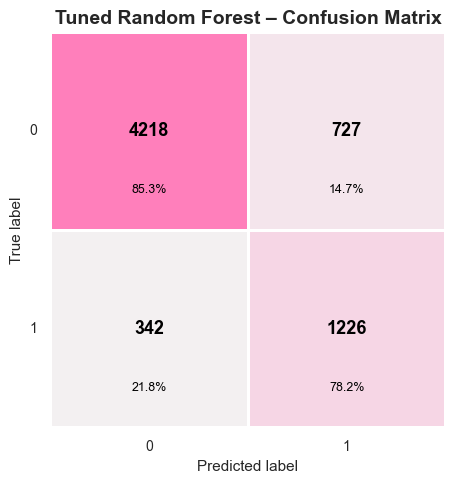

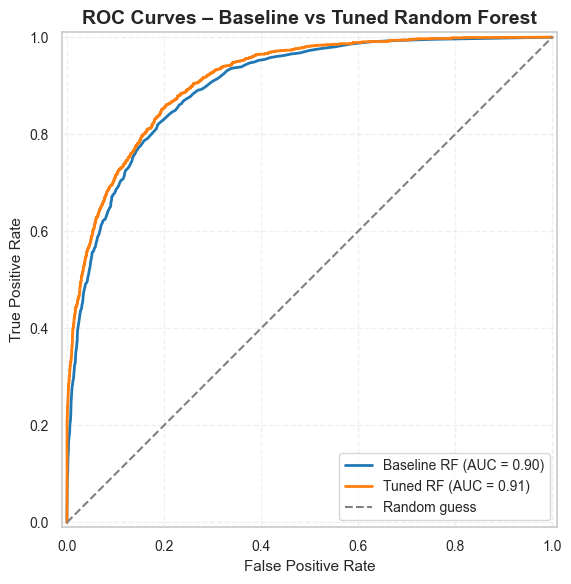

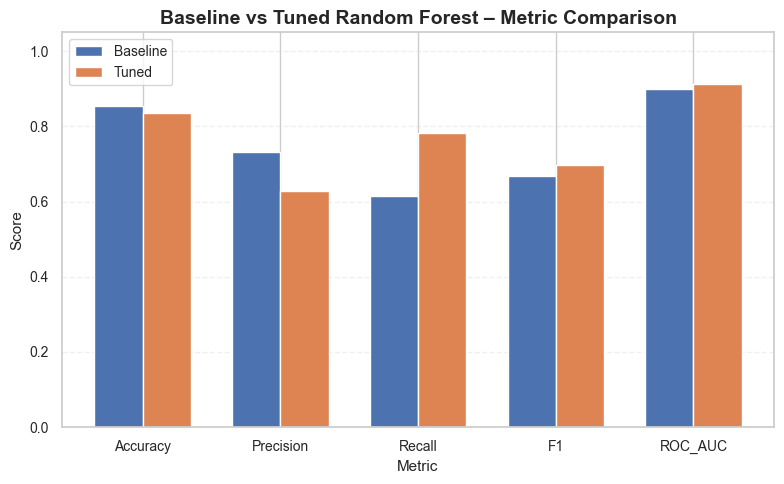

In [14]:
# SECTION 9 – Evaluate tuned model and compare with baseline
# This cell evaluates the tuned Random Forest on the test set, compares it
# numerically and visually with the baseline model, and uses ROC and bar plots
# to present performance improvements clearly for your tutorial audience.

y_pred_tuned = best_pipeline.predict(X_test)
y_proba_tuned = best_pipeline.predict_proba(X_test)[:, 1]

tuned_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_tuned),
    "Precision": precision_score(y_test, y_pred_tuned),
    "Recall": recall_score(y_test, y_pred_tuned),
    "F1": f1_score(y_test, y_pred_tuned),
    "ROC_AUC": roc_auc_score(y_test, y_proba_tuned),
}

print("Tuned Random Forest performance on test set:")
for metric_name, value in tuned_metrics.items():
    print(f"{metric_name:9s}: {value:.3f}")

print("\nBaseline vs Tuned metrics:")
for name in baseline_metrics.keys():
    print(f"{name:9s}: {baseline_metrics[name]:.3f}  ->  {tuned_metrics[name]:.3f}")

print("\nClassification report (tuned model):")
print(classification_report(y_test, y_pred_tuned))

plot_confusion_matrix_pretty(
    y_test,
    y_pred_tuned,
    title="Tuned Random Forest – Confusion Matrix"
)

plot_roc_comparison(
    y_test,
    y_proba_baseline,
    y_proba_tuned
)

plot_metric_bar_comparison(
    baseline_metrics,
    tuned_metrics
)


# 10. Permutation Feature Importance (Advanced Interpretability Plot)

Number of original features: 14
Length of importances vector: 14
Top 10 features by permutation importance:


marital.status    0.050775
capital.gain      0.036604
education.num     0.029741
age               0.014479
occupation        0.009120
capital.loss      0.008859
hours.per.week    0.003224
workclass         0.002057
race             -0.000215
sex              -0.000307
dtype: float64

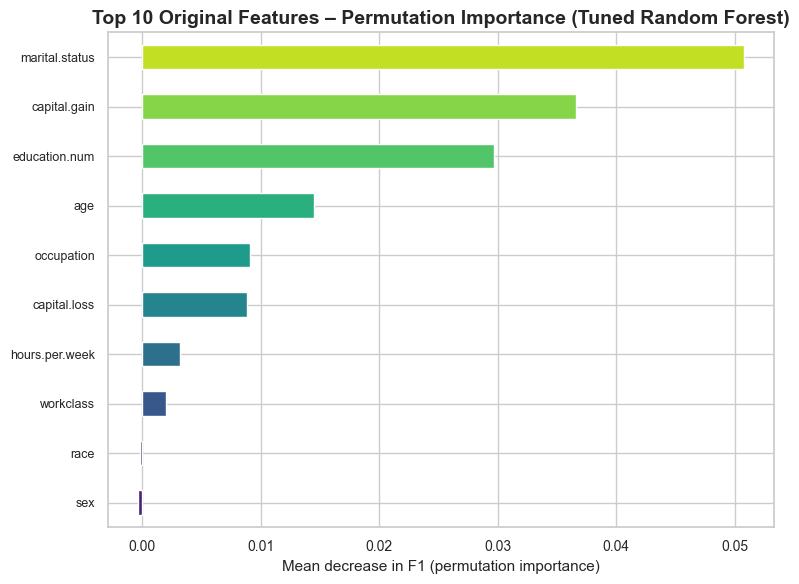

In [16]:
# SECTION 10 – Permutation feature importance for interpretability
# This cell computes permutation feature importance for the tuned model,
# identifies the most influential original input features, and visualises them
# as a horizontal bar chart. This helps you explain what drives the model’s
# decisions in terms of human-readable attributes.

# Compute permutation importance on the full pipeline
result = permutation_importance(
    best_pipeline,
    X_test,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# permutation_importance on a Pipeline returns one importance value
# per original feature column in X (before one-hot encoding).
# Therefore, we should use the original column names as the index.
original_feature_names = X_test.columns
print("Number of original features:", len(original_feature_names))
print("Length of importances vector:", len(result.importances_mean))

# Build a Series mapping each original feature to its mean importance
importances = pd.Series(
    result.importances_mean,
    index=original_feature_names
)

# Select the top-k most important features
top_n = 10
top_importances = importances.sort_values(ascending=False).head(top_n)

print(f"Top {top_n} features by permutation importance:")
display(top_importances)

# Visualise as a horizontal bar chart
plot_feature_importance_bar(
    top_importances,
    title=f"Top {top_n} Original Features – Permutation Importance (Tuned Random Forest)"
)


# 11. Simple Fairness Check by Sex (Optional but Powerful)

In [17]:
# SECTION 11 – Group-wise performance by sex (fairness-inspired analysis)
# This cell explores whether the tuned model behaves differently across
# subgroups defined by the 'sex' attribute. It is not a full fairness audit,
# but it introduces the ethical dimension expected at MSc level.

if "sex" in X.columns:
    X_test_with_y = X_test.copy()
    X_test_with_y["true_label"] = y_test
    X_test_with_y["pred_label"] = y_pred_tuned

    print("Group-wise performance by 'sex' on the tuned model:")
    for group_value, group_df in X_test_with_y.groupby("sex"):
        y_true_g = group_df["true_label"]
        y_pred_g = group_df["pred_label"]

        acc_g = accuracy_score(y_true_g, y_pred_g)
        prec_g = precision_score(y_true_g, y_pred_g, zero_division=0)
        rec_g = recall_score(y_true_g, y_pred_g, zero_division=0)
        f1_g = f1_score(y_true_g, y_pred_g, zero_division=0)

        print(f"\nSex group: {group_value}")
        print(f"  Samples : {len(group_df)}")
        print(f"  Accuracy: {acc_g:.3f}")
        print(f"  Precision: {prec_g:.3f}")
        print(f"  Recall   : {rec_g:.3f}")
        print(f"  F1-score : {f1_g:.3f}")
else:
    print("Column 'sex' not found – group-wise fairness check skipped.")


Group-wise performance by 'sex' on the tuned model:

Sex group: Female
  Samples : 2153
  Accuracy: 0.929
  Precision: 0.673
  Recall   : 0.702
  F1-score : 0.687

Sex group: Male
  Samples : 4360
  Accuracy: 0.790
  Precision: 0.621
  Recall   : 0.796
  F1-score : 0.698
